In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import copy,os

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

import seaborn as sns
sns.set()

In [2]:
df_sales = pd.read_csv('../../data/rdc_sales_1320_replenishment_V1_filled.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)
df_sl = df_sl.reset_index()

In [3]:
data_start_date = df_sl.columns[1]
data_end_date = df_sl.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2016-01-01 to 2018-08-31


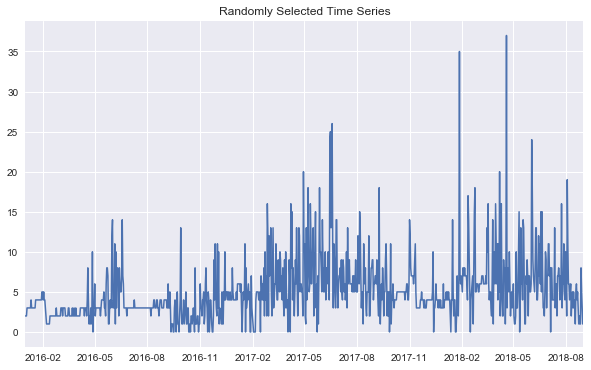

In [4]:

plt.figure(figsize=(10,6))

pd.Series(df_sl.iloc[20016,1:]).astype(np.float64).plot(linewidth=1.5)

plt.title('Randomly Selected Time Series');
    
# plot_random_series(df_sl, 1)

In [47]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [48]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [49]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2016-01-01 00:00:00 - 2018-08-03 00:00:00
Train prediction: 2018-08-04 00:00:00 - 2018-08-17 00:00:00 

Val encoding: 2016-01-15 00:00:00 - 2018-08-17 00:00:00
Val prediction: 2018-08-18 00:00:00 - 2018-08-31 00:00:00

Encoding interval: 946
Prediction interval: 14


In [50]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_sl.columns[1:]]),
                          data=[i for i in range(len(df_sl.columns[1:]))])

series_array = df_sl[df_sl.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
#     series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
#     series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [51]:
first_n_samples = 40000
batch_size = 2**11
epochs = 50

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [52]:
## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 56
# length of output signals
output_seq_len = 14
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph():
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        scope=None):

            with variable_scope.variable_scope(scope or "rnn_decoder"):
                state = initial_state
                outputs = []
                prev = None
                for i, inp in enumerate(decoder_inputs):
                    if i > 0:
                        variable_scope.get_variable_scope().reuse_variables()
                    output, state = cell(inp, state)
                    outputs.append(output)
            return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              dtype=dtypes.float32,
                              scope=None):

            with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
                enc_cell = copy.deepcopy(cell)
                _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
                return _rnn_decoder(decoder_inputs, enc_state, cell)
    
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss
        print(1)

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        print(2)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

In [53]:
total_iteractions = 1
batch_size = 200
KEEP_RATE = 0.5
train_losses = []
val_losses = []

tf.reset_default_graph()
rnn_model = build_graph()
print('Build done.')
saver = tf.train.Saver()

1
2
Build done.


In [54]:
init = tf.global_variables_initializer()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        loss = 0
        for bs in range(first_n_samples//batch_size):
            idx = np.random.randint(first_n_samples//batch_size) * batch_size
            feed_dict = {rnn_model['enc_inp'][t]: 
                         encoder_input_data[idx:idx+batch_size,t+enc_length.days-input_seq_len,:] for t in range(input_seq_len)}
            feed_dict.update({rnn_model['target_seq'][t]: 
                              decoder_target_data[idx:idx+batch_size,t,:] for t in range(output_seq_len)})
            _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
            loss += loss_t*batch_size
        print(loss/first_n_samples)
    
    path = os.path.join('./../logs/temp', 'univariate_ts_model0')
    if not tf.gfile.Exists(path):
        tf.gfile.MakeDirs(path)
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, path)
        
print("Checkpoint saved at: ", save_path)

2.8449470433592796
Checkpoint saved at:  ./../logs/temp/univariate_ts_model0


In [68]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end) 
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [69]:
test_idx = 20016

test_seq_input = encoder_input_data[test_idx,:,:]
test_seq_target = decoder_target_data[test_idx,:,:]

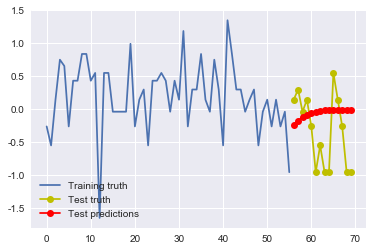

In [59]:
# rnn_model = build_graph()
# init = tf.global_variables_initializer()
REF_TIME = enc_length.days
PRED_LEN = output_seq_len
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./../logs/temp/', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[REF_TIME-input_seq_len+t].reshape(1,1) 
                 for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

l1, = plt.plot(range(input_seq_len), test_seq_input[REF_TIME-input_seq_len:], label = 'Training truth')
l2, = plt.plot(range(input_seq_len, input_seq_len+14), test_seq_target.reshape(-1), 'y-o', label = 'Test truth')
l3, = plt.plot(range(input_seq_len, input_seq_len+14), final_preds[0], 'r-o', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()

## Test on inventory simulation system

In [96]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_pred_end) 
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [97]:
test_idx = 20016

test_seq_input = encoder_input_data[test_idx,:,:]
test_seq_target = decoder_target_data[test_idx,:,:]

In [98]:
simu_start_date = dt.datetime(2018,8,1) - val_enc_start
simu_start_date.days

929

In [109]:
np.random.seed(0)
h = 1
b = 9

N = 4
R = 7
VLT = np.random.choice([3,4,5,6,7], (N,))

simu_start_date = (dt.datetime(2018,8,1) - val_enc_start).days
end_of_horizon = 31
demand = np.exp(test_seq_input[simu_start_date:] + encode_series_mean[test_idx])-1

order_time = []
arrive_time = []
for i in range(N):
    t1 = i*R
    t2 = t1+VLT[i]
    order_time.append(t1)
    arrive_time.append(t2)      

In [110]:
inv0 = int(np.sum(demand[0:VLT[0]]))
inv = inv0 
print('Initial Inventory:', inv0)

Initial Inventory: 54


In [111]:
def countOccurrences(arr, x):
    res = 0
    for i in range(len(arr)):
        if x == arr[i]:
            res += 1
    return res

In [112]:
history_inv = []
order_list = []
h_cost_list = []
b_cost_list = []
cost_list = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(init)
    saver = rnn_model['saver']().restore(sess, os.path.join('./../logs/temp/', 'univariate_ts_model0'))
    
    # simulate the inventory change
    for t in range(order_time[0], end_of_horizon):
        if t in arrive_time:
            occurance = countOccurrences(arrive_time, t)
            while(occurance>0):
                i = arrive_time.index(t)+occurance-1
                print('receiving ',i , 'th order at time', t, 'Order qtty:', order_list[i])
                inv = inv + order_list[i]
                occurance = occurance-1
        
        if t in order_time:
            feed_dict = {rnn_model['enc_inp'][j]: 
                         test_seq_input[simu_start_date+t-input_seq_len+j].reshape(1,1) for j in range(input_seq_len)}
            
            feed_dict.update({rnn_model['target_seq'][j]: np.zeros([1, output_dim]) for j in range(output_seq_len)})
            
            final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
            
            # forecast the sales in next 14 days
            sales_14d_pred = np.exp(final_preds + encode_series_mean[test_idx])-1
            #print('Sales forecast:', sales_14d_pred)
            
            # current order time
            cur_order_index = order_time.index(t)
            
            # current order arrive time
            cur_order_arrive = t + VLT[cur_order_index]
            
            # next order arrive time (expected)
            next_order_arrive = t+R+np.mean(VLT)
            
            # number of days between the current order arrive and next order arrive; the optimal order
            # qtty is the sales sum of [cur_order_arrive: cur_order_arrive+(b/b+h)*days]
            days = np.ceil((next_order_arrive - cur_order_arrive)*(b*1.0/(b+h)))
            
            days = int(days)
            
            order_qtty = int(np.sum(sales_14d_pred[cur_order_arrive-t:cur_order_arrive+days-t]))
            
            order_list.append(order_qtty)
            
            print('placing ', cur_order_index, 'th order at time', t, 'Order qtty:', order_qtty)
        
        inv = inv - demand[t]
        
        h_cost = h*np.maximum(0, inv)
        b_cost = b*np.maximum(0, -inv)
        h_cost_list.append(h_cost)
        b_cost_list.append(b_cost)
        cost_list.append(h_cost+b_cost)
        
        history_inv.append(int(inv))      

placing  0 th order at time 0 Order qtty: 22
receiving  0 th order at time 7 Order qtty: 22
placing  1 th order at time 7 Order qtty: 40
receiving  1 th order at time 10 Order qtty: 40
placing  2 th order at time 14 Order qtty: 25
receiving  2 th order at time 20 Order qtty: 25
placing  3 th order at time 21 Order qtty: 25
receiving  3 th order at time 27 Order qtty: 25


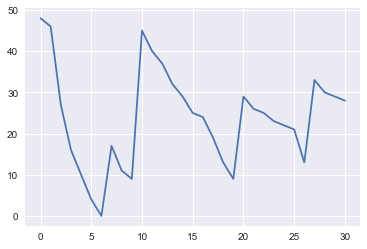

In [113]:
plt.plot(history_inv)